In [1]:
import matplotlib.pyplot as plt
import torch
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import numpy as np
from main_pygod import get_data_from_loader, load_dataset, make_loader, transform_data, create_model, train_model, test_model
import warnings

In [2]:
def create_metrics():
    return {"overall": {"roc_auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []},
            "licit": {"precision": [], "recall": [],"f1-score": []}, 
           "illicit":{"precision": [], "recall": [],"f1-score": []}}

def hyperparameter_loop(group_para, parameter, parameter_list, metrics):
    """ 
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    warnings.filterwarnings('ignore')
    for i in range(len(parameter_list)):
        config[group_para][parameter] = parameter_list[i]
        timestamp = config["model"]["backbone"]+"_hid_dim"+str(config["model"]["hid_dim"])+"_num_l"+str(config["model"]["num_layers"])
        timestamp += "_dropout"+str(config["model"]["dropout"])+ "_epoch"+str(config["model"]["epoch"])
        
        dataset, input_nodes = load_dataset(mask="train",use_aggregated=config["data"]["use_aggregated"],use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)
        train_data1 = get_data_from_loader(loader)
        train_data2 = transform_data(train_data1, perturb=config['transform']['perturb'], 
                                interpolate=config['transform']['interpolate'])

        mymodel = create_model(config=config["model"])

        train_clean = train_model(mymodel, train_data1, output_directory=config["training"]["save_dir"], 
                                    save_embeddings=config["training"]["save_embeddings"], timestamp=timestamp)
        trained_model = train_model(train_clean, train_data2, output_directory=config["training"]["save_dir"], 
                                    save_embeddings=config["training"]["save_embeddings"], timestamp=timestamp)
        
        dataset, input_nodes = load_dataset(mask="test",use_aggregated=config["data"]["use_aggregated"],
        use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes,)    
        test_data = get_data_from_loader(loader)

        test_metrics = test_model(model=trained_model, data=test_data, output_directory=config["training"]["save_dir"], timestamp=timestamp)

        for key in list(test_metrics.keys())[0:-1]:
            metrics["overall"][key].append(test_metrics[key])
        output = test_metrics["classification_report"]
        for key in list(output["0"].keys())[0:-1]:
            metrics["licit"][key].append(output["0"][key])
            metrics["illicit"][key].append(output["1"][key])
            
    return metrics

def plot_metrics(metrics, para_list, parameter, x_log = False):
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 

    size = (8,3)
    plt.figure(figsize= size)
    for key in list(metrics["overall"]):
        plt.plot(para_list, metrics["overall"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Total Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Overall Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["licit"]):
        plt.plot(para_list, metrics["licit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Licit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Licit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["illicit"]):
        plt.plot(para_list, metrics["illicit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Illicit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Illicit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

## Base DOMINANT

In [4]:
config = {
        "model": {
            "hid_dim": 128,
            "num_layers": 5,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gcn",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 10000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":False,
            "interpolate":True,
        }
    }

#### Number of layers

In [6]:

metrics = create_metrics()
para_change = "num_layers"
para_list = [3,4,5,6]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20162, 93], edge_index=[2, 19936], y=[20162])
Using interpolation
creating model with {'hid_dim': 128, 'num_layers': 3, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 3606.9333 | 
Epoch 0001: Loss 3637.1337 | 
Epoch 0002: Loss 806.7637 | 
Epoch 0003: Loss 323.4829 | 
Epoch 0004: Loss 201.0287 | 
Epoch 0005: Loss 126.9640 | 
Epoch 0006: Loss 98.2770 | 
Epoch 0007: Loss 99.7123 | 
Epoch 0008: Loss 120.6726 | 
Epoch 0009: Loss 170.9752 | 
Epoch 0010: Loss 198.1325 | 
Epoch 0011: Loss 149.5617 | 
Epoch 0012: Loss 77.5317 | 
Epoch 0013: Loss 68.6148 | 
Epoch 0014: Loss 70.5925 | 
Epoch 0015: Loss 82.9666 | 
Epoch 0016: Loss 93.0565 | 
Epoch 0017: Loss 92.7110 | 
Epoch 0018: Loss 80.1

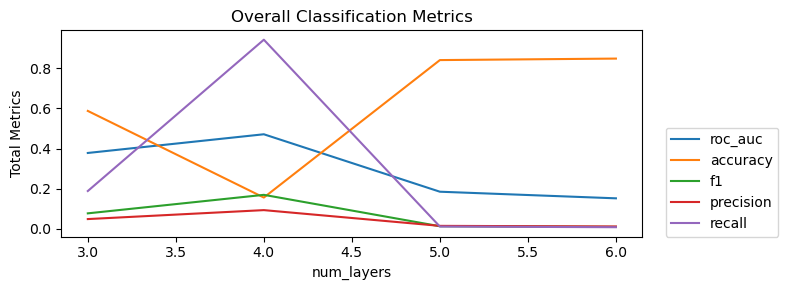

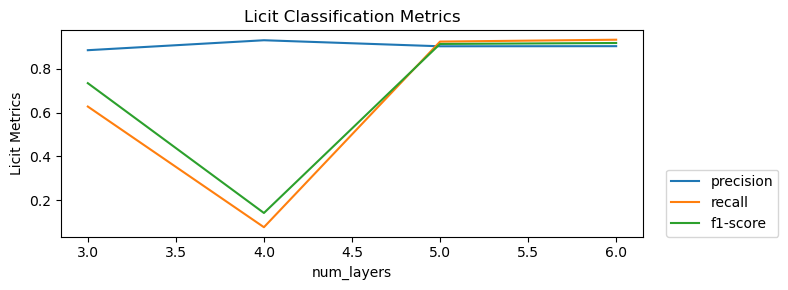

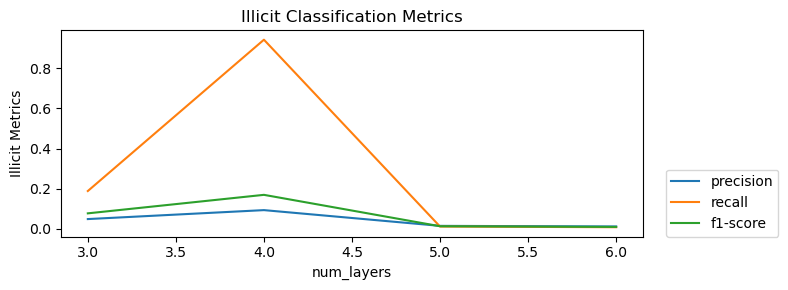

In [7]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [9]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [64, 128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using interpolation
creating model with {'hid_dim': 64, 'num_layers': 6, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 255.1987 | 
Epoch 0001: Loss 13.8927 | 
Epoch 0002: Loss 6.4511 | 
Epoch 0003: Loss 5.2651 | 
Epoch 0004: Loss 4.9614 | 
Epoch 0005: Loss 4.7904 | 
Epoch 0006: Loss 4.7476 | 
Epoch 0007: Loss 4.6491 | 
Epoch 0008: Loss 4.7341 | 
Epoch 0009: Loss 4.5958 | 
Epoch 0010: Loss 4.6021 | 
Epoch 0011: Loss 4.5855 | 
Epoch 0012: Loss 4.5455 | 
Epoch 0013: Loss 4.5399 | 
Epoch 0014: Loss 4.4850 | 
Epoch 0015: Loss 4.5077 | 
Epoch 0016: Loss 4.4552 | 
Epoch 0017: Loss 4.4481 | 
Epoch 0018: Loss 4.3841 | 
Epoch 0019: Loss 4.375

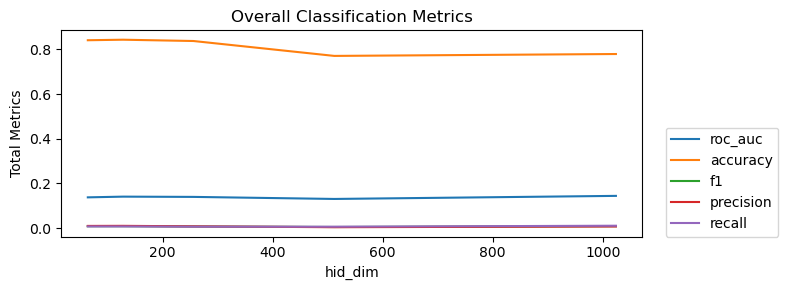

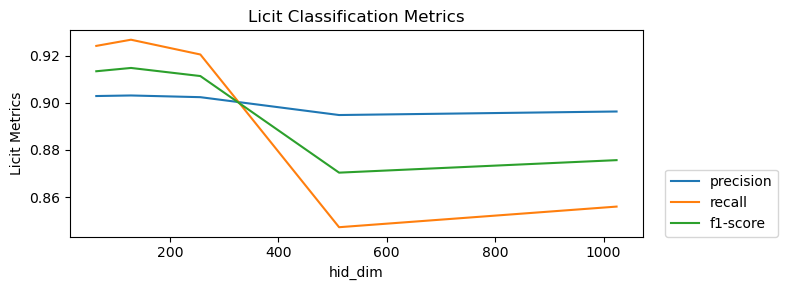

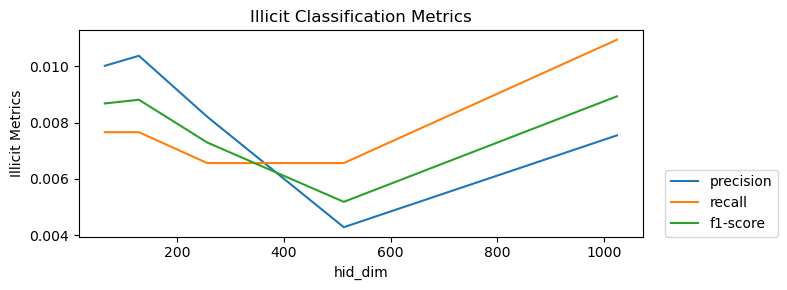

In [10]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [12]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 6, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 232528.9134 | 
Epoch 0001: Loss 38.7126 | 
Epoch 0002: Loss 24.0595 | 
Epoch 0003: Loss 11.4009 | 
Epoch 0004: Loss 8.9289 | 
Epoch 0005: Loss 7.9475 | 
Epoch 0006: Loss 7.2373 | 
Epoch 0007: Loss 6.9079 | 
Epoch 0008: Loss 6.5853 | 
Epoch 0009: Loss 6.3028 | 
Epoch 0010: Loss 6.1733 | 
Epoch 0011: Loss 6.0733 | 
Epoch 0012: Loss 6.6252 | 
Epoch 0013: Loss 6.0308 | 
Epoch 0014: Loss 5.9611 | 
Epoch 0015: Loss 5.8254 | 
Epoch 0016: Loss 5.8771 | 
Epoch 0017: Loss 5.8100 | 
Epoch 0018: Loss 6.1323 | 
Epoch 0019: Los

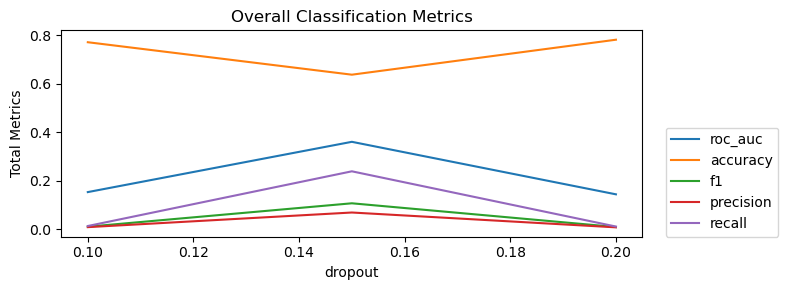

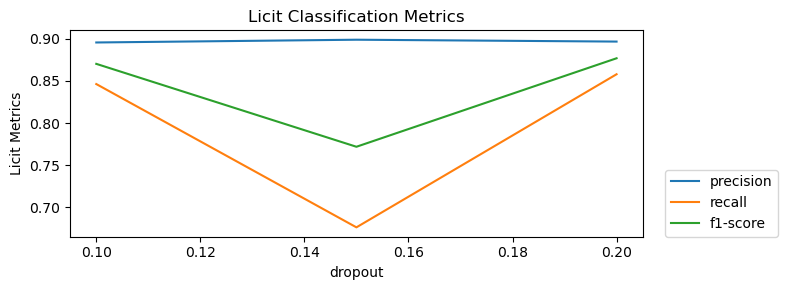

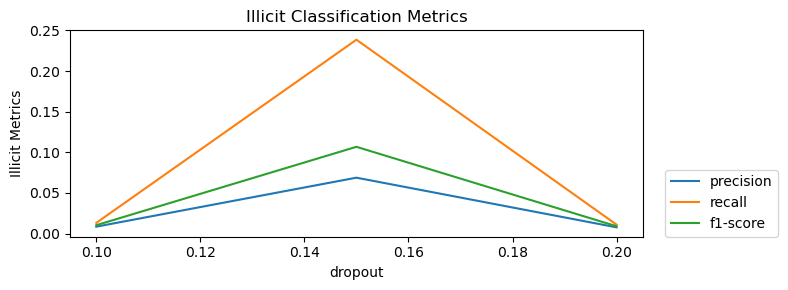

In [13]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [15]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[20166, 93], edge_index=[2, 19946], y=[20166])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 6, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 230711.5027 | 
Epoch 0001: Loss 23.6769 | 
Epoch 0002: Loss 16.0510 | 
Epoch 0003: Loss 12.6521 | 
Epoch 0004: Loss 12.3884 | 
Epoch 0005: Loss 10.2597 | 
Epoch 0006: Loss 8.0514 | 
Epoch 0007: Loss 7.4114 | 
Epoch 0008: Loss 7.1191 | 
Epoch 0009: Loss 6.8695 | 
Epoch 0010: Loss 6.8618 | 
Epoch 0011: Loss 6.7093 | 
Epoch 0012: Loss 6.6582 | 
Epoch 0013: Loss 6.5561 | 
Epoch 0014: Loss 6.4665 | 
Epoch 0015: Loss 6.4087 | 
Epoch 0016: Loss 6.4326 | 
Epoch 0017: Loss 6.3093 | 
Epoch 0018: Loss 6.2264 | 
Epoch 0019: L

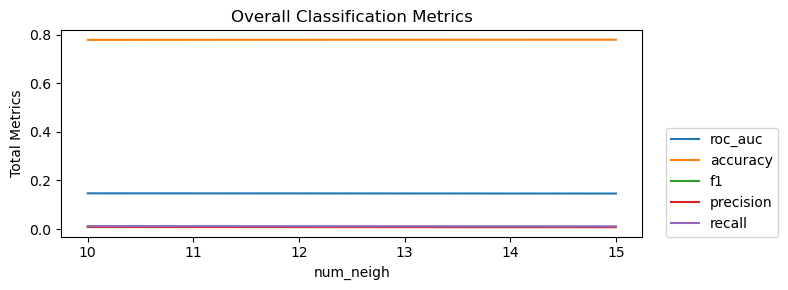

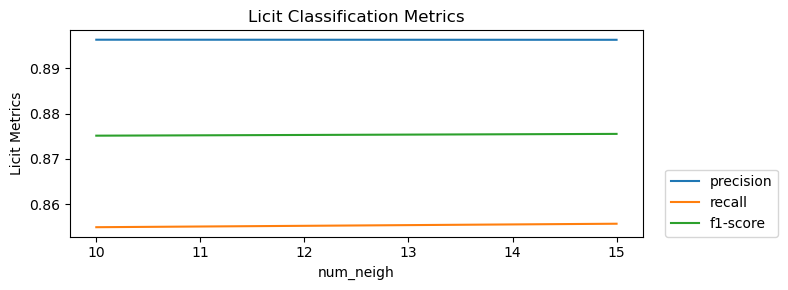

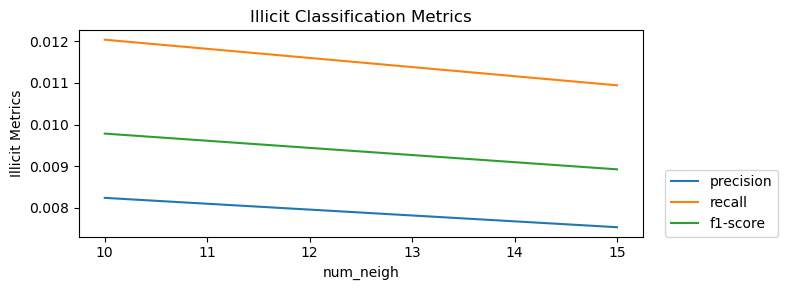

In [16]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [18]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [50, 70]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [19]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using GAT backbone

In [21]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gat",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 15,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":False,
            "interpolate":True,
        }
    }

#### Number of layers

In [23]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [5,6,7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[9996, 93], edge_index=[2, 10010], y=[9996])
Using interpolation
creating model with {'hid_dim': 512, 'num_layers': 5, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 59727.7959 | 
Epoch 0001: Loss 18702.4026 | 
Epoch 0002: Loss 8830.5142 | 
Epoch 0003: Loss 3193.6369 | 
Epoch 0004: Loss 2535.8187 | 
Epoch 0005: Loss 1859.2118 | 
Epoch 0006: Loss 2259.6708 | 
Epoch 0007: Loss 1241.5451 | 
Epoch 0008: Loss 628.6826 | 
Epoch 0009: Loss 763.7906 | 
Epoch 0010: Loss 382.7453 | 
Epoch 0011: Loss 260.7636 | 
Epoch 0012: Loss 191.0824 | 
Epoch 0013: Loss 133.1147 | 
Epoch 0014: Loss 154.0473 | 
Epoch 0015: Loss 101.2181 | 
Epoch 0016: Loss 126.6264 | 
Epoch 0017: Loss 97.3850 | 
Epoch 0018: Loss 94.821

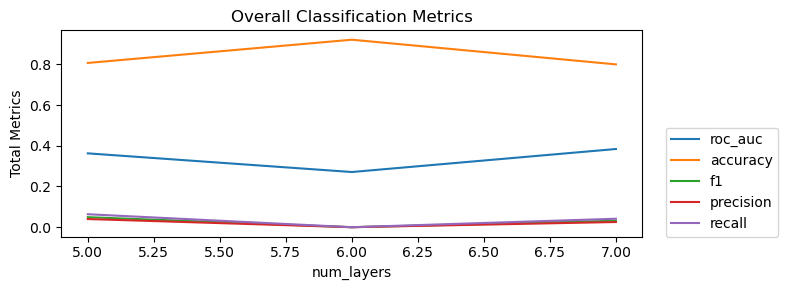

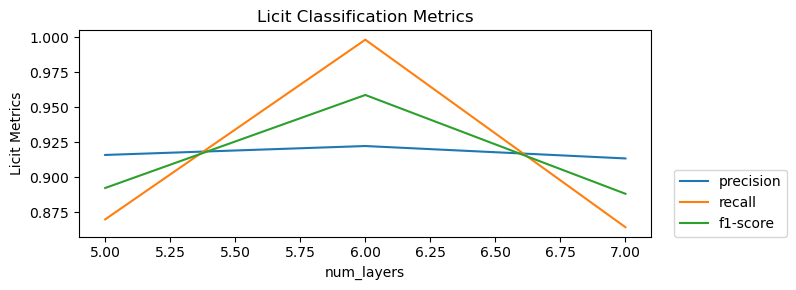

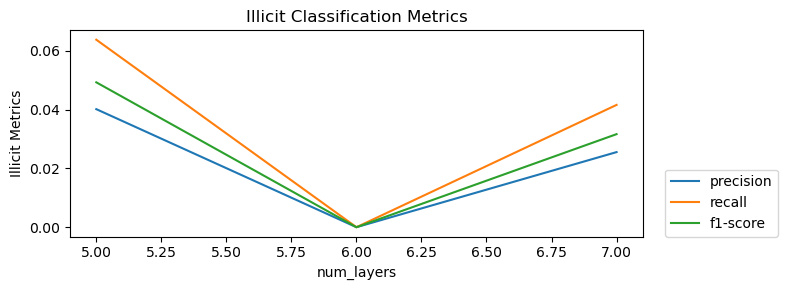

In [24]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [26]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 2136.9377 | 
Epoch 0001: Loss 330.6497 | 
Epoch 0002: Loss 446.4757 | 
Epoch 0003: Loss 151.2892 | 
Epoch 0004: Loss 62.1601 | 
Epoch 0005: Loss 59.4752 | 
Epoch 0006: Loss 52.8262 | 
Epoch 0007: Loss 74.1791 | 
Epoch 0008: Loss 72.8379 | 
Epoch 0009: Loss 81.4535 | 
Epoch 0010: Loss 76.3287 | 
Epoch 0011: Loss 61.5441 | 
Epoch 0012: Loss 60.6585 | 
Epoch 0013: Loss 33.9131 | 
Epoch 0014: Loss 23.4190 | 
Epoch 0015: Loss 15.3176 | 
Epoch 0016: Loss 11.5074 | 
Epoch 0017: Loss 11.5477 | 
Epoch 0018: Loss 11.3138 | 
Epoch 0019: Los

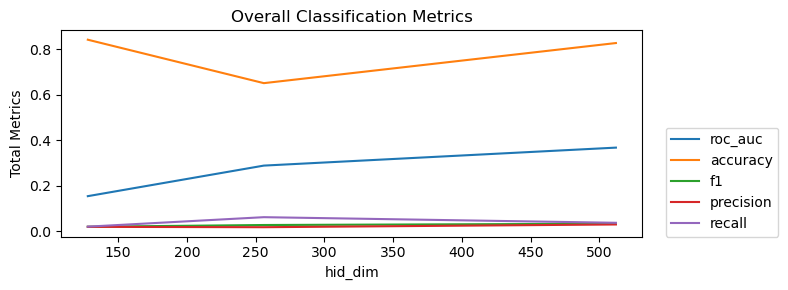

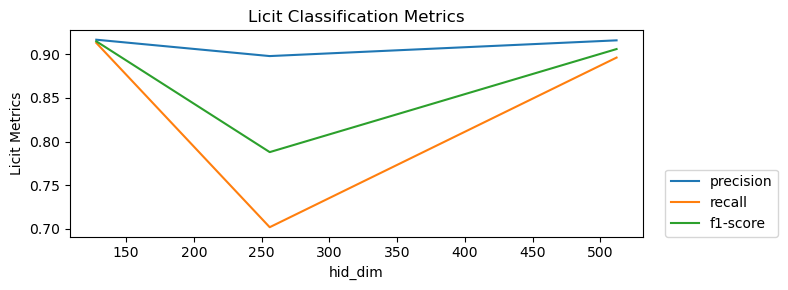

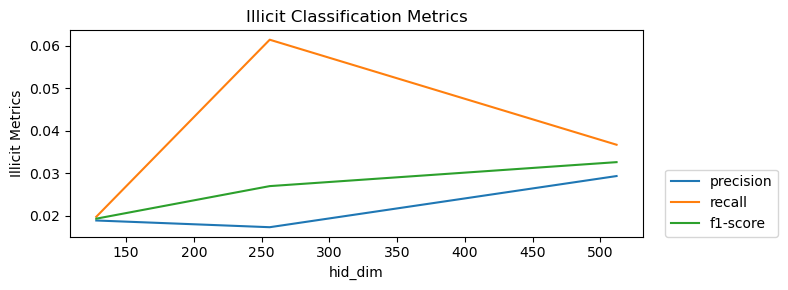

In [27]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [29]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 512, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 15, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 106866.3734 | 
Epoch 0001: Loss 12235.3591 | 
Epoch 0002: Loss 12448.0731 | 
Epoch 0003: Loss 5726.5432 | 
Epoch 0004: Loss 3320.1560 | 
Epoch 0005: Loss 1568.8319 | 
Epoch 0006: Loss 1965.0697 | 
Epoch 0007: Loss 867.7476 | 
Epoch 0008: Loss 1281.6431 | 
Epoch 0009: Loss 813.0182 | 
Epoch 0010: Loss 673.8063 | 
Epoch 0011: Loss 745.2729 | 
Epoch 0012: Loss 740.5300 | 
Epoch 0013: Loss 712.5098 | 
Epoch 0014: Loss 585.4345 | 
Epoch 0015: Loss 542.8436 | 
Epoch 0016: Loss 353.3296 | 
Epoch 0017: Loss 301.6372 | 
Epoch 0018: Loss 2

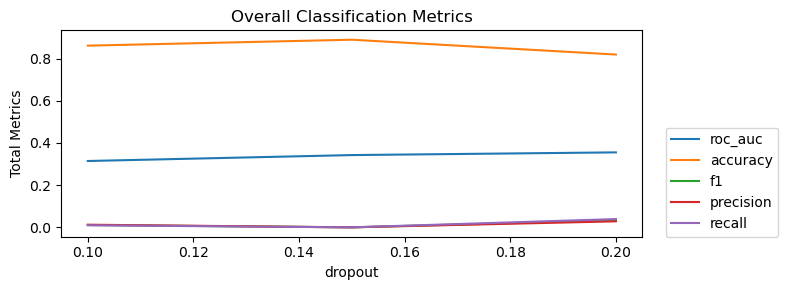

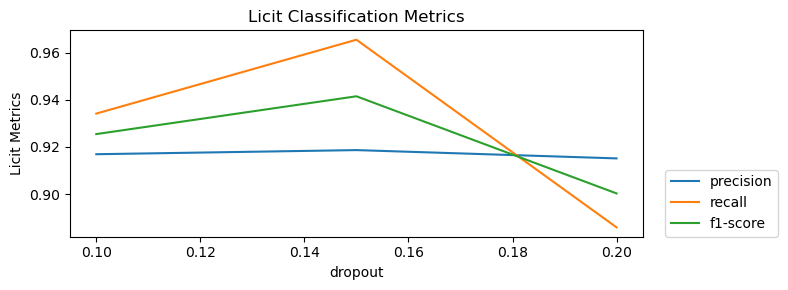

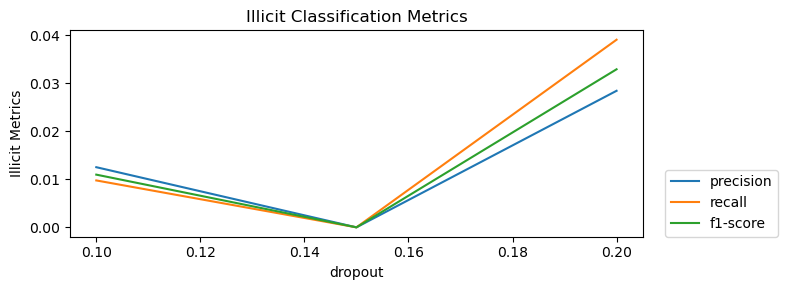

In [30]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [32]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 512, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GATBackbone'>}
training model...
Epoch 0000: Loss 106709.7245 | 
Epoch 0001: Loss 16050.6100 | 
Epoch 0002: Loss 17715.3449 | 
Epoch 0003: Loss 12769.7848 | 
Epoch 0004: Loss 3493.4565 | 
Epoch 0005: Loss 5009.6436 | 
Epoch 0006: Loss 3869.5975 | 
Epoch 0007: Loss 1404.6265 | 
Epoch 0008: Loss 1051.9636 | 
Epoch 0009: Loss 775.9633 | 
Epoch 0010: Loss 342.6074 | 
Epoch 0011: Loss 240.2737 | 
Epoch 0012: Loss 230.3481 | 
Epoch 0013: Loss 166.2547 | 
Epoch 0014: Loss 120.9145 | 
Epoch 0015: Loss 110.8981 | 
Epoch 0016: Loss 100.0558 | 
Epoch 0017: Loss 88.7445 | 
Epoch 0018: Loss 

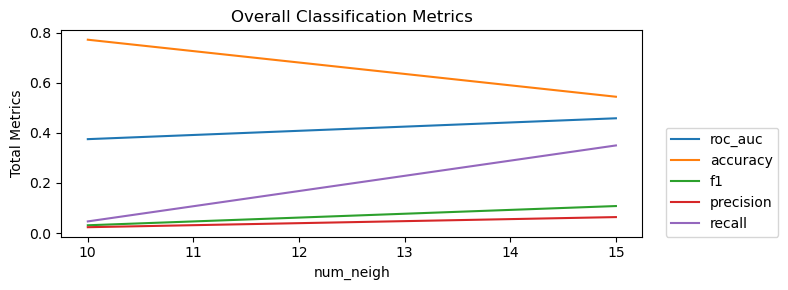

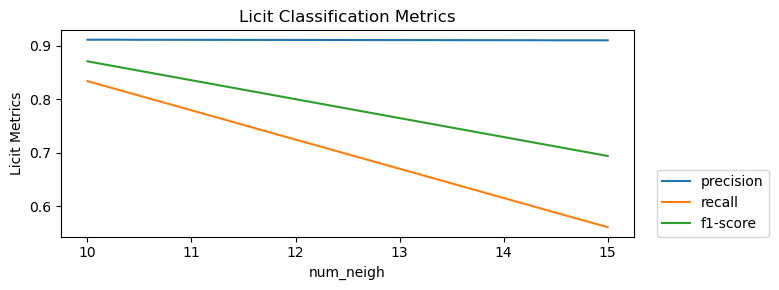

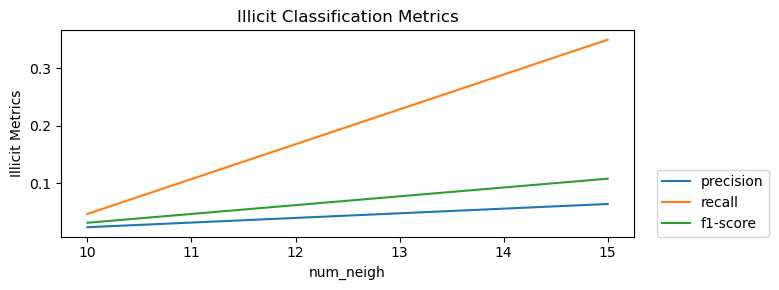

In [33]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [35]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [10, 20 , 30 , 40, 50]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [36]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using hybrid GCN/GAT backbone

In [38]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "hybrid",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":False,
            "interpolate":True,
        }
    }

#### Number of layers

In [40]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [4, 5, 6, 7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 512, 'num_layers': 4, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 5960.4116 | 
Epoch 0001: Loss 3601.3029 | 
Epoch 0002: Loss 2805.9086 | 
Epoch 0003: Loss 2519.0288 | 
Epoch 0004: Loss 2321.3637 | 
Epoch 0005: Loss 2107.3974 | 
Epoch 0006: Loss 1908.8813 | 
Epoch 0007: Loss 1733.5306 | 
Epoch 0008: Loss 1604.3644 | 
Epoch 0009: Loss 1486.3832 | 
Epoch 0010: Loss 1399.7015 | 
Epoch 0011: Loss 1289.3739 | 
Epoch 0012: Loss 1189.8225 | 
Epoch 0013: Loss 1074.3047 | 
Epoch 0014: Loss 992.8419 | 
Epoch 0015: Loss 867.5338 | 
Epoch 0016: Loss 758.0753 | 
Epoch 0017: Loss 592.9103 | 
Epoch 0

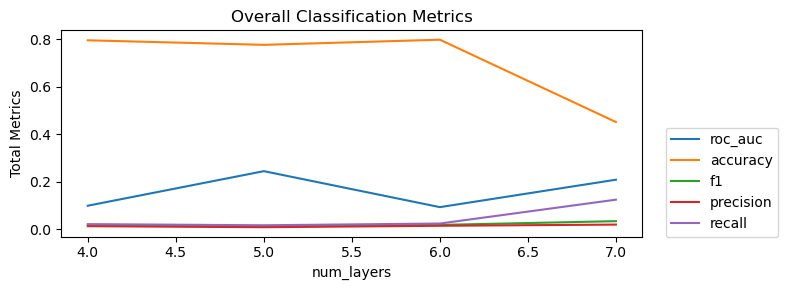

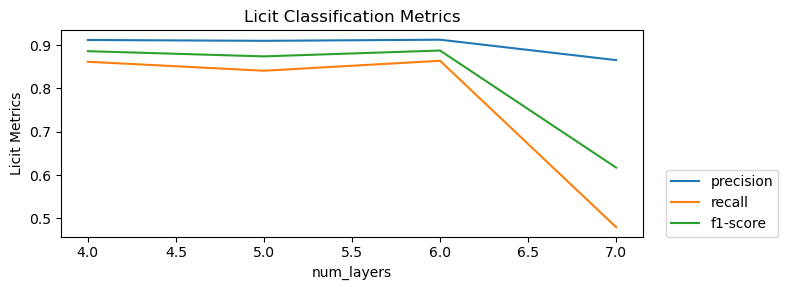

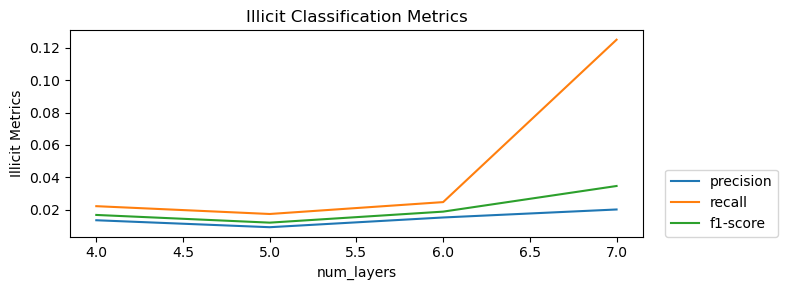

In [41]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [43]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 928.8023 | 
Epoch 0001: Loss 533.9798 | 
Epoch 0002: Loss 340.1606 | 
Epoch 0003: Loss 269.9161 | 
Epoch 0004: Loss 224.5646 | 
Epoch 0005: Loss 186.1217 | 
Epoch 0006: Loss 167.3528 | 
Epoch 0007: Loss 157.8808 | 
Epoch 0008: Loss 158.0444 | 
Epoch 0009: Loss 162.6451 | 
Epoch 0010: Loss 141.1328 | 
Epoch 0011: Loss 130.6704 | 
Epoch 0012: Loss 119.2629 | 
Epoch 0013: Loss 124.3625 | 
Epoch 0014: Loss 114.1663 | 
Epoch 0015: Loss 117.7352 | 
Epoch 0016: Loss 111.8240 | 
Epoch 0017: Loss 119.5785 | 
Epoch 0018: Loss 114.

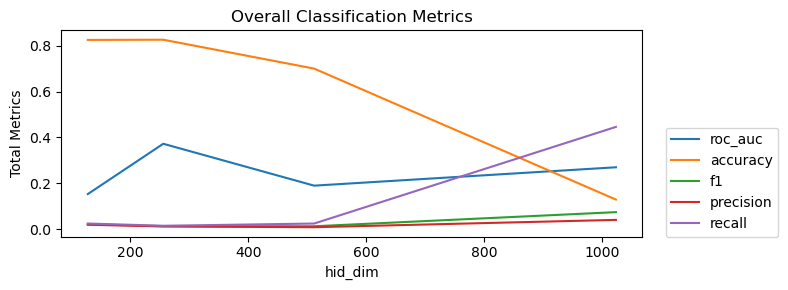

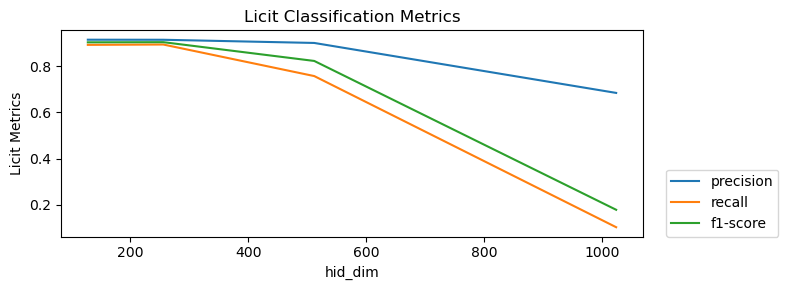

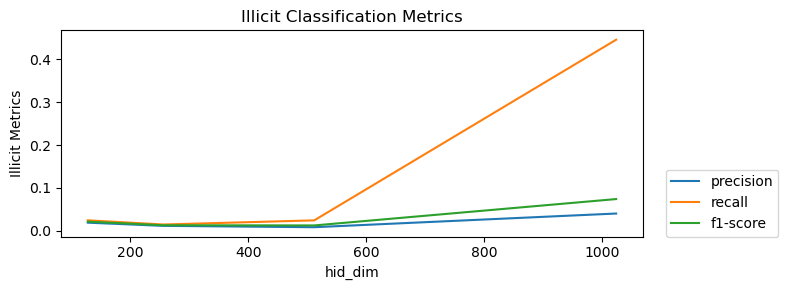

In [44]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [46]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 10600.4156 | 
Epoch 0001: Loss 5771.1851 | 
Epoch 0002: Loss 4287.0318 | 
Epoch 0003: Loss 3363.0260 | 
Epoch 0004: Loss 2983.7381 | 
Epoch 0005: Loss 2462.0610 | 
Epoch 0006: Loss 2110.3385 | 
Epoch 0007: Loss 1847.1098 | 
Epoch 0008: Loss 1661.0725 | 
Epoch 0009: Loss 1516.5071 | 
Epoch 0010: Loss 1413.5805 | 
Epoch 0011: Loss 1279.5633 | 
Epoch 0012: Loss 1195.5210 | 
Epoch 0013: Loss 1075.3329 | 
Epoch 0014: Loss 990.1971 | 
Epoch 0015: Loss 869.3940 | 
Epoch 0016: Loss 771.6284 | 
Epoch 0017: Loss 679.6704 | 
Epoch

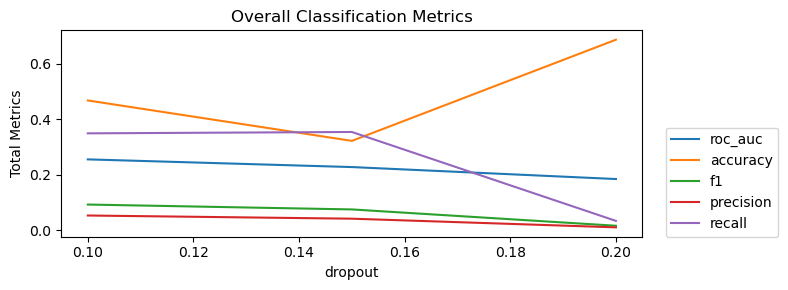

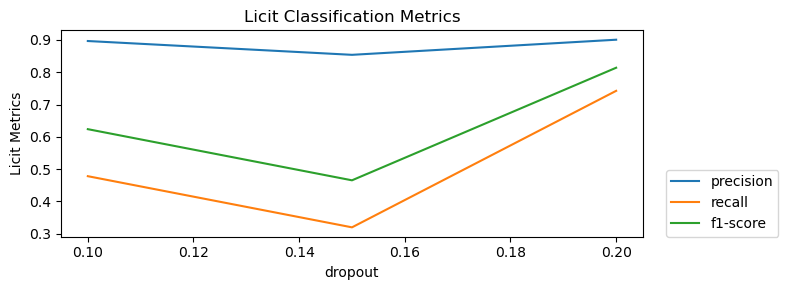

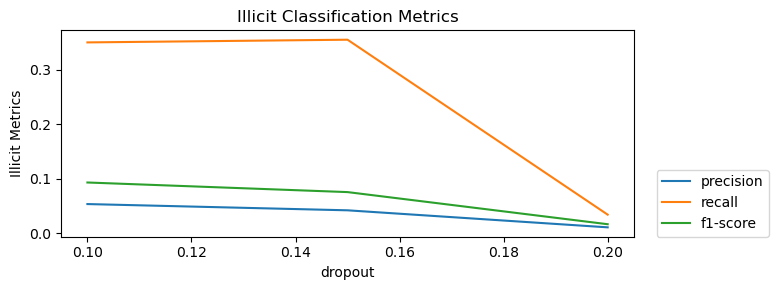

In [47]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [49]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.HybridGCNGATBackbone'>}
training model...
Epoch 0000: Loss 9959.3933 | 
Epoch 0001: Loss 5068.9173 | 
Epoch 0002: Loss 3822.3622 | 
Epoch 0003: Loss 3172.7933 | 
Epoch 0004: Loss 3053.0300 | 
Epoch 0005: Loss 2718.8723 | 
Epoch 0006: Loss 2597.9256 | 
Epoch 0007: Loss 2367.0234 | 
Epoch 0008: Loss 2147.3701 | 
Epoch 0009: Loss 1929.8896 | 
Epoch 0010: Loss 1735.8513 | 
Epoch 0011: Loss 1632.7032 | 
Epoch 0012: Loss 1525.5766 | 
Epoch 0013: Loss 1410.8559 | 
Epoch 0014: Loss 1283.8910 | 
Epoch 0015: Loss 1162.6673 | 
Epoch 0016: Loss 1024.0496 | 
Epoch 0017: Loss 898.8861 | 
Epo

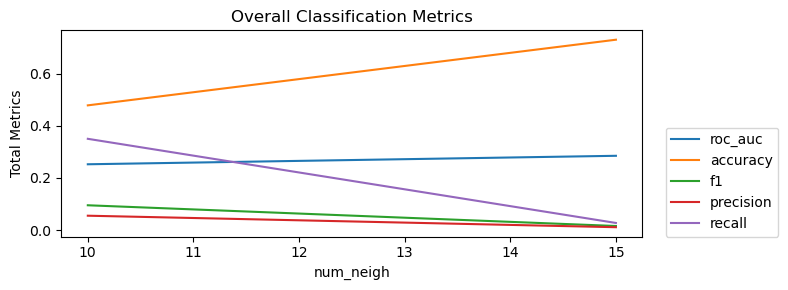

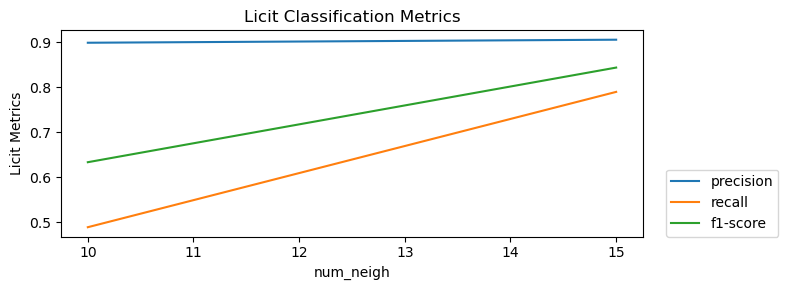

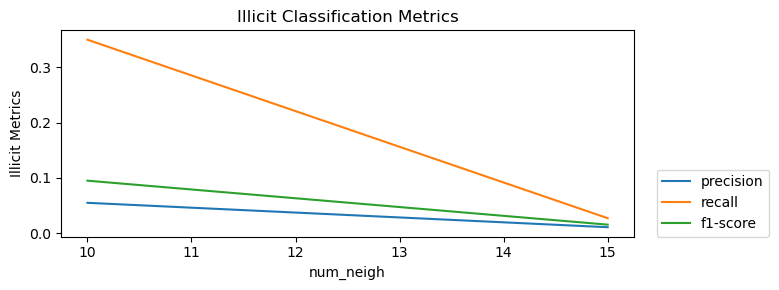

In [50]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [52]:
# metrics = create_metrics()
# para_change = "epoch"
# para_list = [40, 50]

# metrics = hyperparameter_loop("model", para_change, para_list, metrics)

In [53]:
# plot_metrics(metrics, para_list, para_change, x_log=False)

## DOMINANT using Skip-GCN Backbone

In [55]:
config = {
        "model": {
            "hid_dim": 512,
            "num_layers": 6,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gcn_skip",
            "lr": 0.005,
            "epoch": 30,
            "gpu":0.9,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 5000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
        "transform":{
            "perturb":False,
            "interpolate":True,
        }
    }

#### Number of Layers

In [57]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [4, 5, 6, 7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 512, 'num_layers': 4, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 8435.9334 | 
Epoch 0001: Loss 2716.0668 | 
Epoch 0002: Loss 1449.7419 | 
Epoch 0003: Loss 920.6911 | 
Epoch 0004: Loss 657.6396 | 
Epoch 0005: Loss 501.4891 | 
Epoch 0006: Loss 414.2976 | 
Epoch 0007: Loss 349.9869 | 
Epoch 0008: Loss 311.8314 | 
Epoch 0009: Loss 279.1803 | 
Epoch 0010: Loss 244.4895 | 
Epoch 0011: Loss 237.7294 | 
Epoch 0012: Loss 217.6708 | 
Epoch 0013: Loss 215.2503 | 
Epoch 0014: Loss 198.5444 | 
Epoch 0015: Loss 190.0346 | 
Epoch 0016: Loss 191.4460 | 
Epoch 0017: Loss 181.0418 | 
Epoch 0018: Loss 183.64

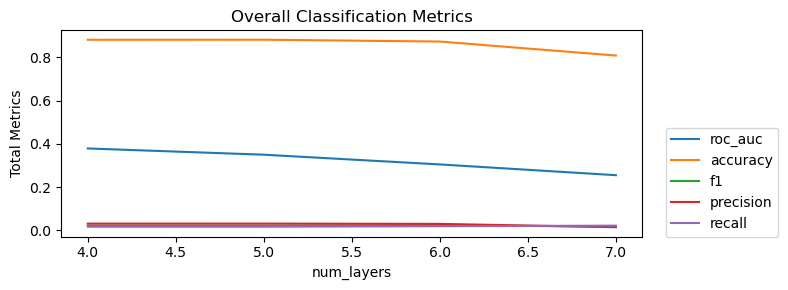

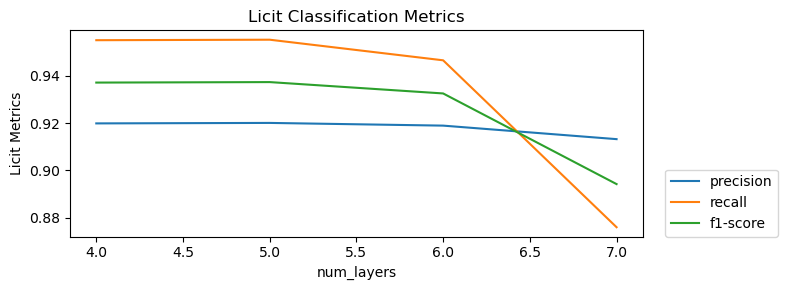

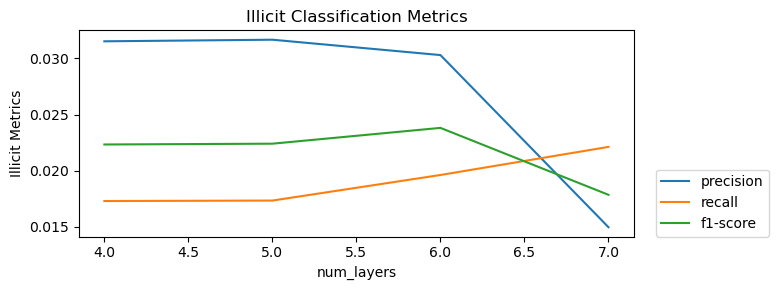

In [58]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [60]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 128, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 2571.5951 | 
Epoch 0001: Loss 379.8401 | 
Epoch 0002: Loss 219.0041 | 
Epoch 0003: Loss 175.5591 | 
Epoch 0004: Loss 148.7880 | 
Epoch 0005: Loss 131.0571 | 
Epoch 0006: Loss 112.4254 | 
Epoch 0007: Loss 103.7104 | 
Epoch 0008: Loss 94.9105 | 
Epoch 0009: Loss 83.4796 | 
Epoch 0010: Loss 84.6311 | 
Epoch 0011: Loss 77.9151 | 
Epoch 0012: Loss 74.5462 | 
Epoch 0013: Loss 68.6474 | 
Epoch 0014: Loss 65.3778 | 
Epoch 0015: Loss 65.4476 | 
Epoch 0016: Loss 64.9904 | 
Epoch 0017: Loss 60.7691 | 
Epoch 0018: Loss 56.1247 | 
Epoch 0

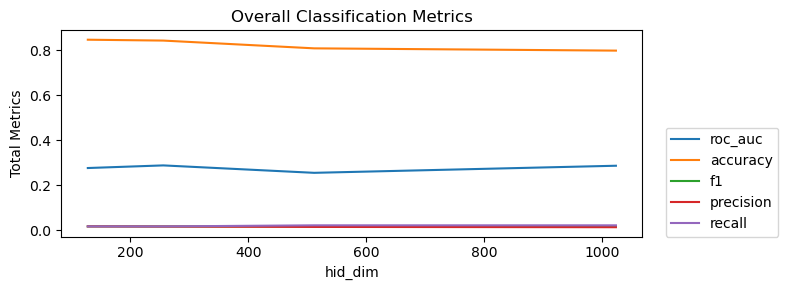

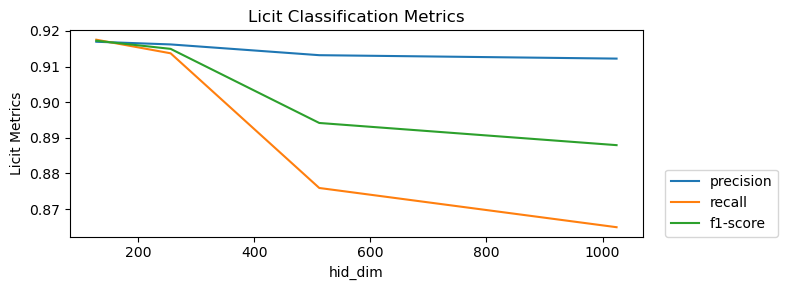

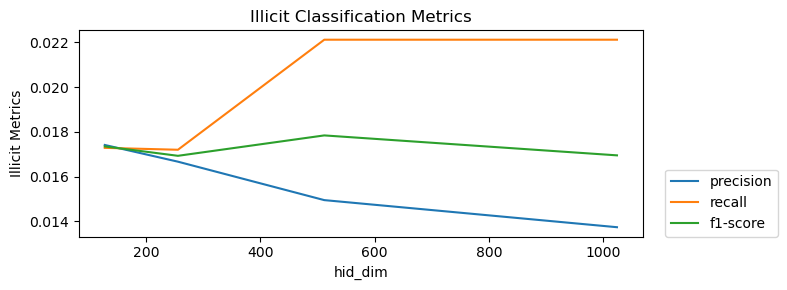

In [61]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [63]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.1, 0.15, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.1, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 27761.0127 | 
Epoch 0001: Loss 8337.2975 | 
Epoch 0002: Loss 5018.0383 | 
Epoch 0003: Loss 3517.6733 | 
Epoch 0004: Loss 2736.9283 | 
Epoch 0005: Loss 2250.4046 | 
Epoch 0006: Loss 1906.6117 | 
Epoch 0007: Loss 1616.4248 | 
Epoch 0008: Loss 1373.6782 | 
Epoch 0009: Loss 1176.5869 | 
Epoch 0010: Loss 1027.0912 | 
Epoch 0011: Loss 895.0085 | 
Epoch 0012: Loss 784.5945 | 
Epoch 0013: Loss 693.9786 | 
Epoch 0014: Loss 627.0504 | 
Epoch 0015: Loss 574.5330 | 
Epoch 0016: Loss 525.6810 | 
Epoch 0017: Loss 484.7982 | 
Epoch 0018: L

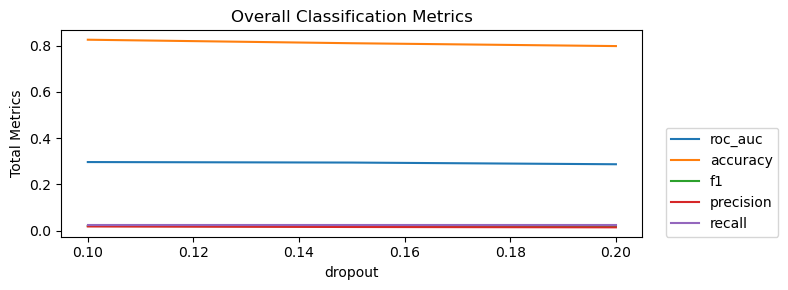

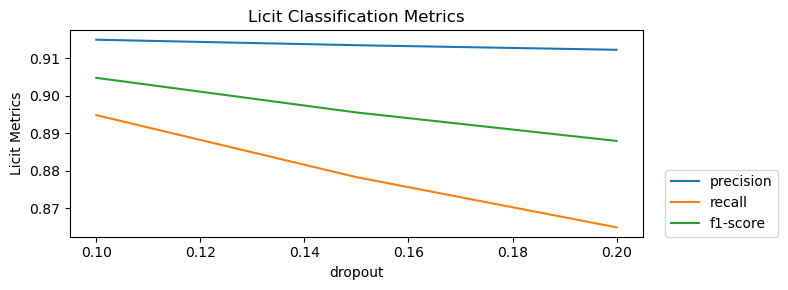

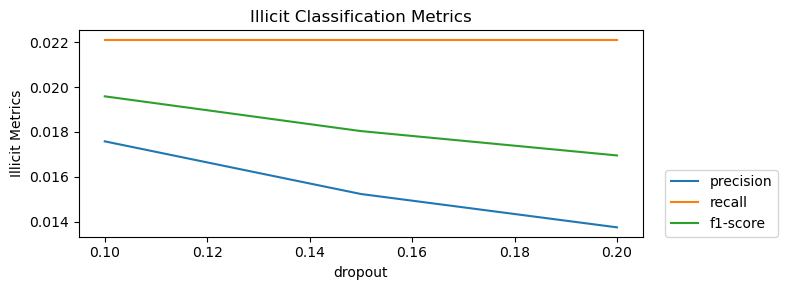

In [64]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [66]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [10,15]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[10018, 93], edge_index=[2, 10017], y=[10018])
Using interpolation
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x000001EE53C5DAB0>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 30, 'gpu': 0.9, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 27631.4482 | 
Epoch 0001: Loss 8272.6816 | 
Epoch 0002: Loss 4547.4421 | 
Epoch 0003: Loss 3022.3730 | 
Epoch 0004: Loss 2315.7289 | 
Epoch 0005: Loss 1848.5461 | 
Epoch 0006: Loss 1562.5140 | 
Epoch 0007: Loss 1317.4179 | 
Epoch 0008: Loss 1088.9690 | 
Epoch 0009: Loss 976.2369 | 
Epoch 0010: Loss 871.3963 | 
Epoch 0011: Loss 764.9617 | 
Epoch 0012: Loss 696.9252 | 
Epoch 0013: Loss 662.3585 | 
Epoch 0014: Loss 603.7000 | 
Epoch 0015: Loss 580.4894 | 
Epoch 0016: Loss 569.7929 | 
Epoch 0017: Loss 532.7261 | 
Epoch 0018: Los

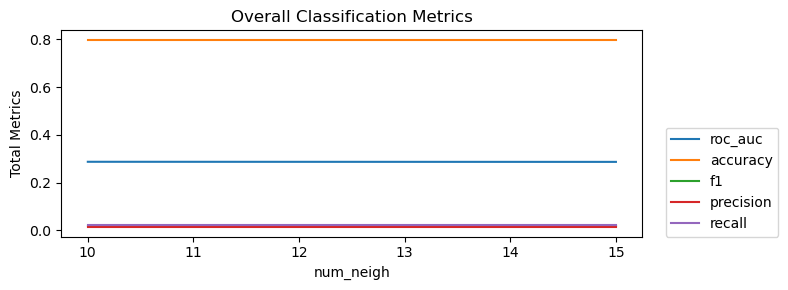

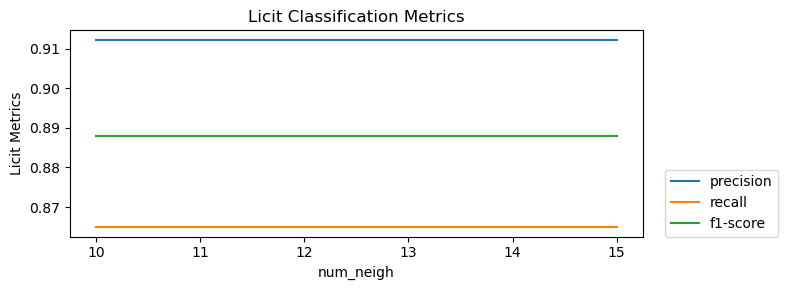

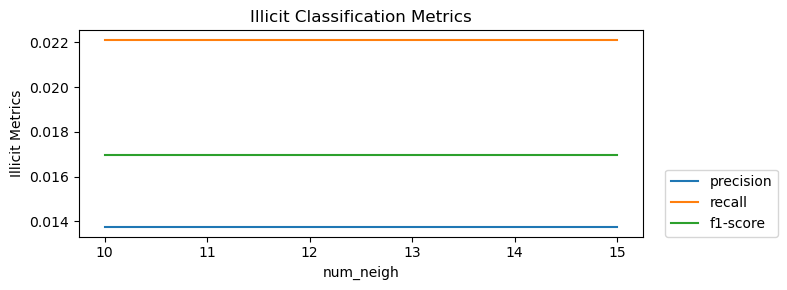

In [67]:
plot_metrics(metrics, para_list, para_change, x_log=False)